In [1]:
from IPython.display import display, clear_output
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

from utils import z_normalize_column, synchronize_trials, remove_artifacts_from_column, bandpass, segment_column, decompose_segment, extract_features, top_bot_25, train
from plots import plot_preprocessing, plot_sample_durations, plot_eeg_gradcpt_time_diff

subject_id = 2

eeg_data_1 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-1.csv')
gradcpt_data_1 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-1.csv')
eeg_data_2 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-2.csv')
gradcpt_data_2 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-2.csv')
eeg_data_3 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-3.csv')
gradcpt_data_3 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-3.csv')

# Channels
channels = ['AF7', 'AF8', 'TP9', 'TP10'] 

# Add a column to indicate the trial number
eeg_data_1['trial'] = 1
gradcpt_data_1['trial'] = 1
eeg_data_2['trial'] = 2
gradcpt_data_2['trial'] = 2
eeg_data_3['trial'] = 3
gradcpt_data_3['trial'] = 3

In [2]:
# Sync trial start and end times

eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, eeg_data_2, eeg_data_3], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, gradcpt_data_2, gradcpt_data_3], ignore_index=True)

Gradcpt data had to be truncated
Gradcpt data had to be truncated


### z-normalization

In [3]:
for channel in channels:
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])

### Remove artifacts

In [4]:
for channel in channels:
    eeg_data[f'{channel}_artif_removed'] = remove_artifacts_from_column(eeg_data[f'{channel}_normal'])

### Bandpass

In [5]:
for channel in channels:
    eeg_data[f'{channel}_bandpassed'] = bandpass(eeg_data[f'{channel}_artif_removed'])

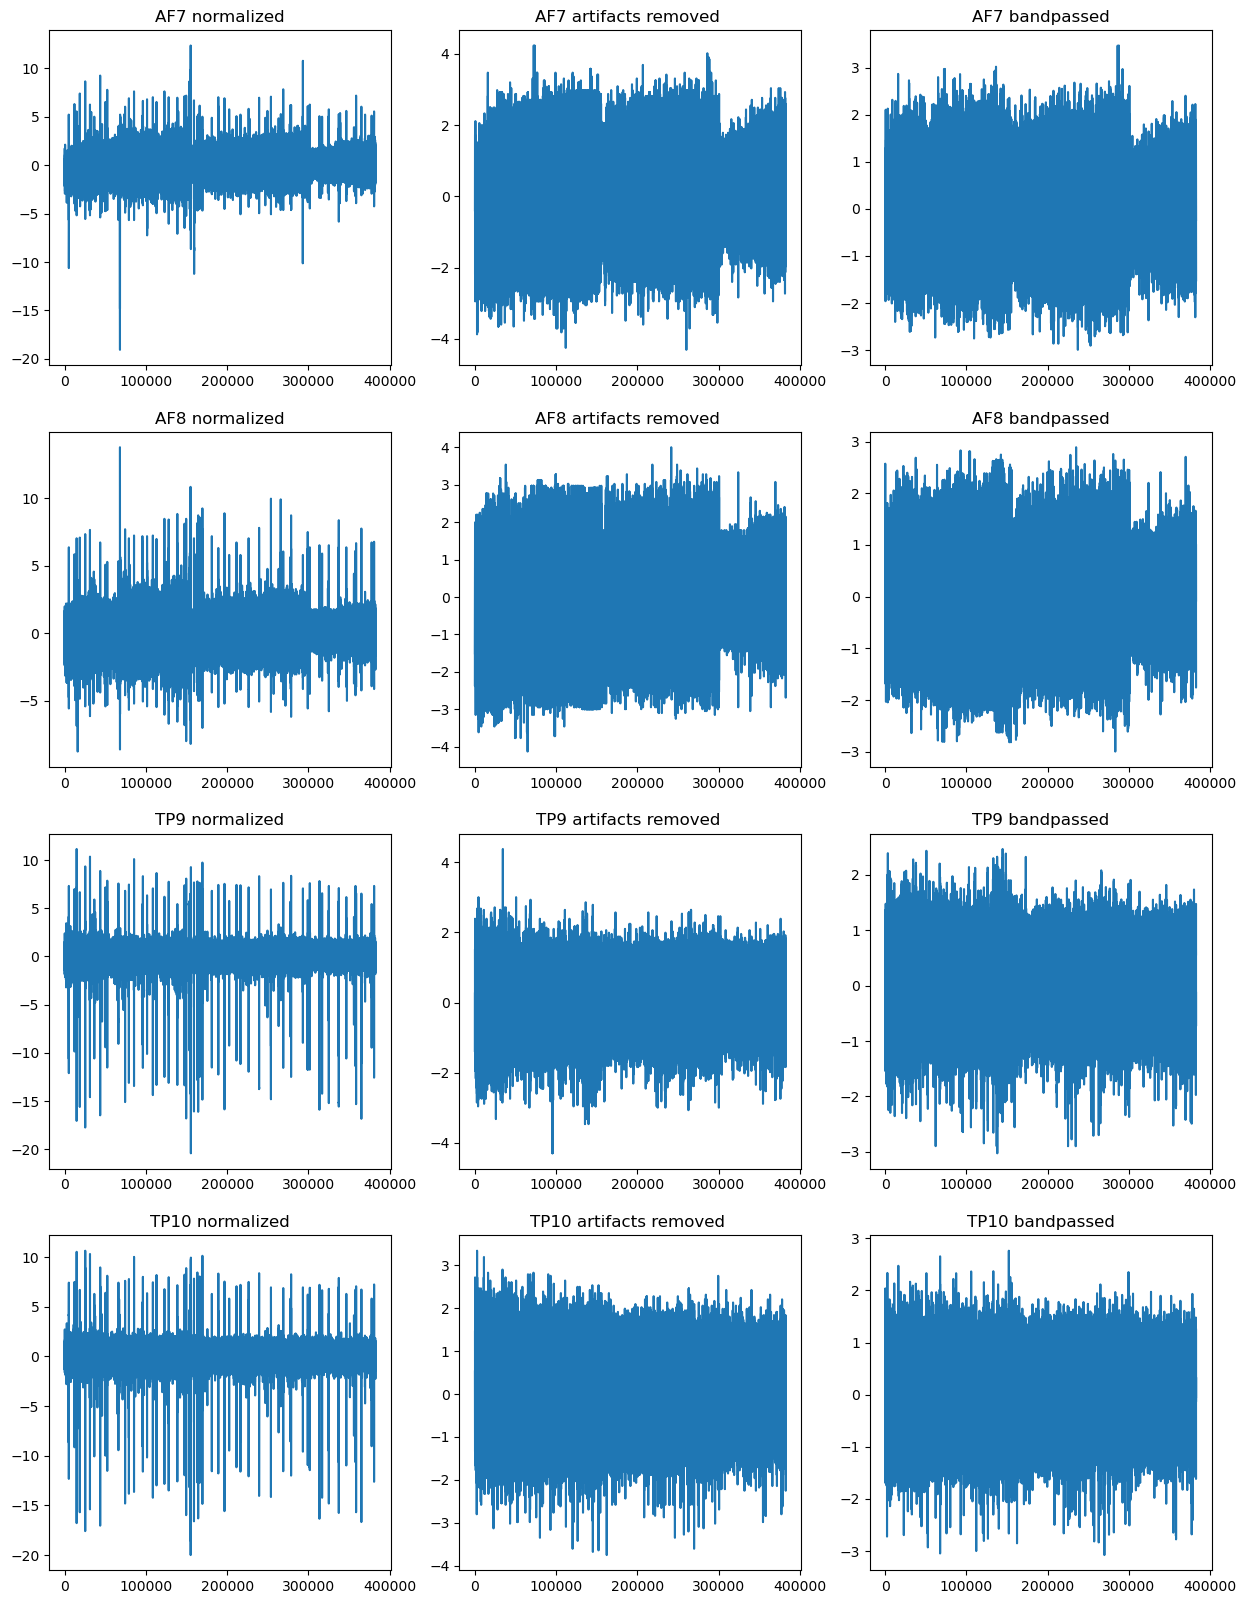

In [6]:
plot_preprocessing(channels=channels, eeg_df=eeg_data)

### Separate trials

In [7]:
# Separate preprocessed data back into individual trials
eeg_data_t1 = eeg_data[eeg_data['trial'] == 1].drop(columns=['trial'])
gradcpt_data_t1 = gradcpt_data[gradcpt_data['trial'] == 1].drop(columns=['trial'])

eeg_data_t2 = eeg_data[eeg_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t2 = gradcpt_data[gradcpt_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)

eeg_data_t3 = eeg_data[eeg_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t3 = gradcpt_data[gradcpt_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)

### Time differences in trials

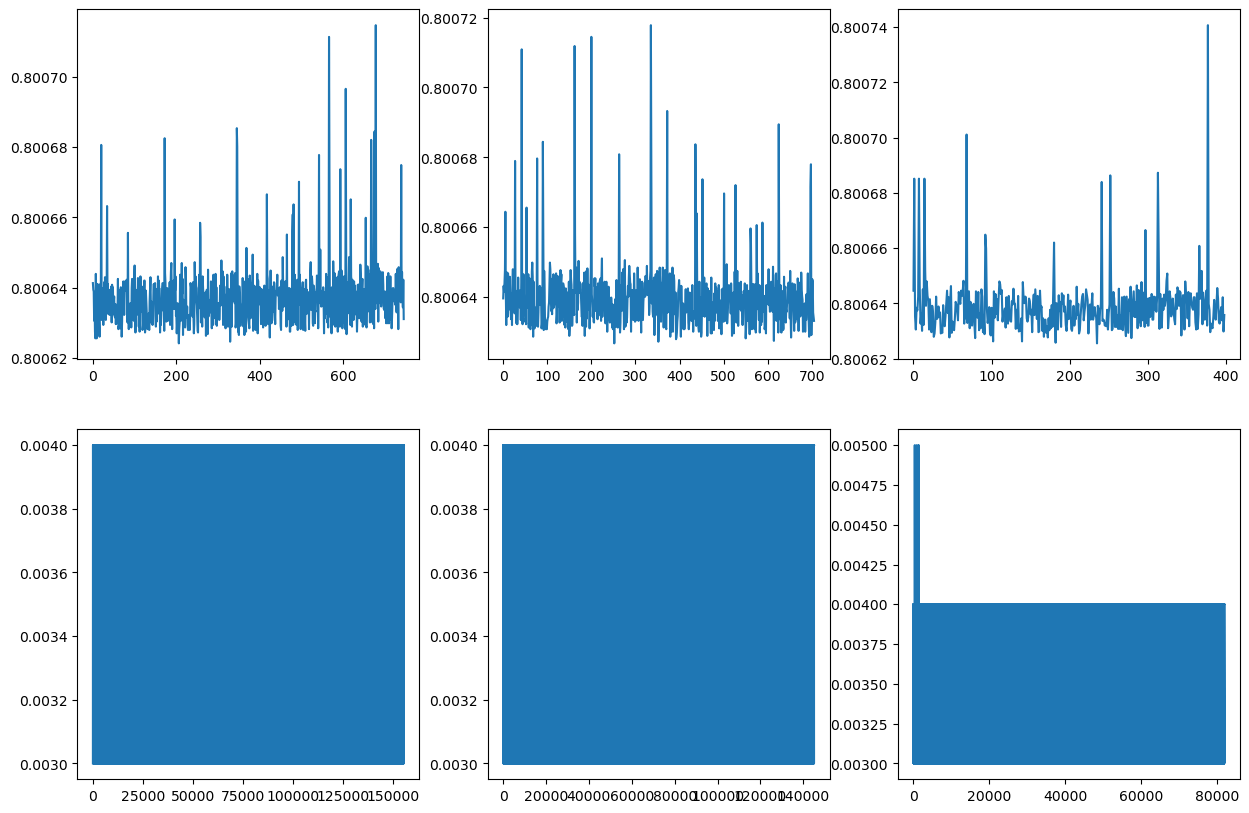

In [8]:
eeg_trials = [eeg_data_t1, eeg_data_t2, eeg_data_t3]
gradcpt_trials = [gradcpt_data_t1, gradcpt_data_t2, gradcpt_data_t3]
plot_sample_durations(eeg_trials, gradcpt_trials)

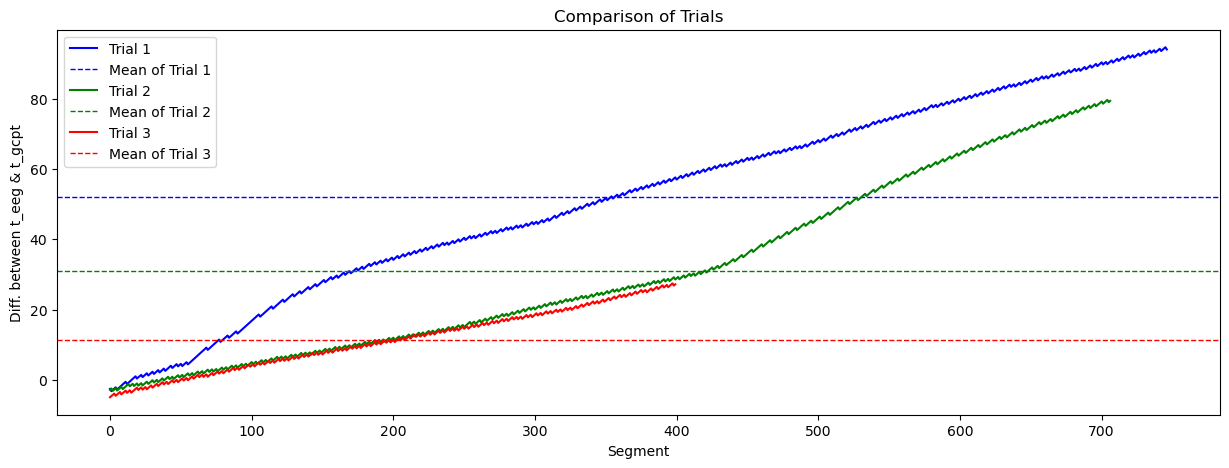

In [9]:
plot_eeg_gradcpt_time_diff(eeg_trials, gradcpt_trials)

### Extract features

In [13]:

import pywt
import numpy as np
import pandas as pd
from scipy.stats import entropy, skew, ttest_ind
from scipy.ndimage import binary_closing, binary_opening
from scipy.signal import filtfilt, butter, welch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.model_selection import train_test_split,  StratifiedKFold, GridSearchCV
from sklearn.linear_model import (RidgeClassifierCV,RidgeClassifier)
from sklearn.svm import SVC
from detach_rocket.detach_rocket.detach_classes import DetachMatrix, DetachRocket
import matplotlib.pyplot as plt

# Features defined below
def extract_features(channel, segments):
    # Define bands and features for clarity and extensibility
    bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    
    # Calculate features for each segment and store them
    features_data = []
    for i in range(len(segments)):
        segment_features = {}
        for band in bands:
            signal = segments[i][band]  # Assuming each segment is a dict with band-labeled keys
            
            # Existing features
            segment_features[f'{channel}_{band}_approx_entropy'] = approximate_entropy(signal)
            segment_features[f'{channel}_{band}_total_variation'] = total_variation(signal)
            segment_features[f'{channel}_{band}_standard_deviation'] = standard_deviation(signal)
            segment_features[f'{channel}_{band}_energy'] = energy(signal)
            segment_features[f'{channel}_{band}_skewness'] = skewness(signal)
            
            # New features
            _, psd = power_spectral_density(signal)
            segment_features[f'{channel}_{band}_psd_mean'] = np.mean(psd)
            segment_features[f'{channel}_{band}_spectral_entropy'] = spectral_entropy(signal)
            segment_features[f'{channel}_{band}_sef'] = spectral_edge_frequency(signal)
            
            # Hjorth parameters (as separate features)
            activity, mobility, complexity = hjorth_parameters(signal)
            segment_features[f'{channel}_{band}_hjorth_activity'] = activity
            segment_features[f'{channel}_{band}_hjorth_mobility'] = mobility
            segment_features[f'{channel}_{band}_hjorth_complexity'] = complexity    
        features_data.append(segment_features)
    
    # Now, for each segment, append features from preceding 9 windows
    augmented_features_data = []
    
    for i in range(len(features_data)):
        augmented_features = {}
        for j in range(max(0, i-9), i+1):
            for key, value in features_data[j].items():
                # Adjust the key to include the window index relative to the current segment
                augmented_key = f'{key}_win{j-i}'
                augmented_features[augmented_key] = value
                
        augmented_features_data.append(augmented_features)
    
    # Create a DataFrame from the augmented features data
    features_df = pd.DataFrame(augmented_features_data)
    features_df.fillna(0, inplace=True)

    return features_df



# FEATURES
def approximate_entropy(signal, m=2, r=None):
    def _maxdist(x_i, x_j):
        return np.max(np.abs(x_i - x_j), axis=1)

    def _phi(m, x, N, r):
        C = np.zeros(len(x))
        for i, x_i in enumerate(x):
            # Calculate distance in a vectorized manner
            dists = _maxdist(x_i, x)
            # Count the number of distances less than or equal to r
            C[i] = np.sum(dists <= r) / (N - m + 1.0)
        C += 1e-10  # To avoid log(0)
        
        return np.sum(np.log(C)) / (N - m + 1.0)

    # Ensure 'signal' is a numpy array
    U = np.array(signal)
    N = len(U)

    # Set the similarity criterion 'r' if it is not provided
    if r is None:
        r = 0.2 * np.std(signal)
        
    # Precompute slices of U for different values of m
    x_m = [np.array([U[j:j+m] for j in range(N - m + 1)]) for m in [m, m+1]]
    
    # Calculate approximate entropy using precomputed slices
    return abs(_phi(m + 1, x_m[1], N, r) - _phi(m, x_m[0], N, r))


def total_variation(signal):
    return np.sum(np.abs(np.diff(signal)))

def standard_deviation(signal):
    return np.std(signal)

def energy(signal):
    return np.sum(np.square(signal))

def skewness(signal):
    return skew(signal)

def power_spectral_density(signal, fs=256):
    f, Pxx = welch(signal, fs=fs)
    return f, Pxx

def spectral_entropy(signal, fs=256, method='fft', normalize=False):
    if method == 'welch':
        f, psd = welch(signal, fs=fs)
    else:
        psd = np.abs(np.fft.fft(signal))**2
        psd = psd[:len(psd)//2]
    
    psd /= psd.sum()  # Normalize the PSD
    se = entropy(psd, base=2)
    
    if normalize:
        se /= np.log2(psd.size)
    
    return se

def spectral_edge_frequency(signal, fs=256, edge=0.9):
    f, Pxx = welch(signal, fs=fs)
    cumulative_power = np.cumsum(Pxx)
    total_power = cumulative_power[-1]
    edge_freq = f[np.where(cumulative_power >= total_power * edge)[0][0]]
    
    return edge_freq

def hjorth_parameters(signal):
    activity = np.var(signal)
    gradient = np.diff(signal)
    mobility = np.sqrt(np.var(gradient) / activity)
    gradient2 = np.diff(gradient)
    mobility_derivative = np.sqrt(np.var(gradient2) / np.var(gradient))
    complexity = mobility_derivative / mobility
    
    return activity, mobility, complexity

In [14]:
# Initialize empty DataFrames for each trial
features_t1 = pd.DataFrame()
features_t2 = pd.DataFrame()
features_t3 = pd.DataFrame()

for trial in [1, 2, 3]:
    # Select the current trial data
    if trial == 1:
        cur_eeg_df = eeg_data_t1
        cur_gcpt_df = gradcpt_data_t1
    elif trial == 2:
        cur_eeg_df = eeg_data_t2
        cur_gcpt_df = gradcpt_data_t2
    else:
        cur_eeg_df = eeg_data_t3
        cur_gcpt_df = gradcpt_data_t3
    
    # Process each channel
    for i, channel in enumerate(channels):
        # Segment the current EEG data
        segments = segment_column(cur_eeg_df[f'{channel}_bandpassed'], cur_gcpt_df)
        # Decompose each segment
        segment_bands = [decompose_segment(segment) for segment in segments]
        # Extract features from the decomposed segments
        features = extract_features(channel, segment_bands)
        
        # Append the features to the respective DataFrame
        if trial == 1:
            features_t1 = pd.concat([features_t1, features], axis=1)
        elif trial == 2:
            features_t2 = pd.concat([features_t2, features], axis=1)
        else:
            features_t3 = pd.concat([features_t3, features], axis=1)
        
        clear_output(wait=True)
        print(f'{(trial-1)*len(channels)+i+1}/{3*len(channels)} Done')

features_t1['in_the_zone'] = gradcpt_data_t1['in_the_zone']
features_t2['in_the_zone'] = gradcpt_data_t2['in_the_zone']
features_t3['in_the_zone'] = gradcpt_data_t3['in_the_zone']

12/12 Done


In [15]:
combined_features_df = pd.concat([features_t1, features_t2, features_t3], ignore_index=True)

## Detach rocket

### Train and eval

In [63]:
from detach_rocket.detach_rocket.detach_classes import DetachMatrix
from sklearn.model_selection import train_test_split

X = combined_features_df.iloc[:, :-1]
y = combined_features_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

detach_matrix = DetachMatrix(trade_off=0.1)
detach_matrix.fit(X_train, y_train)

# Evaluate Performance on Test Set
detach_test_score, full_test_score= detach_matrix.score(X_test, y_test)
print('Test Accuraccy Full Model: {:.2f}%'.format(100*full_test_score))
print('Test Accuraccy Detach Model: {:.2f}%'.format(100*detach_test_score))

TRAINING RESULTS Full Features:
Optimal Alpha Full Features: 54555.95
Train Accuraccy Full Features: 65.26%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 73.00
Train Accuraccy Detach Model: 58.61%
-------------------------
Test Accuraccy Full Model: 57.97%
Test Accuraccy Detach Model: 49.64%


### Plot SFD Curve and Optimal Model selection

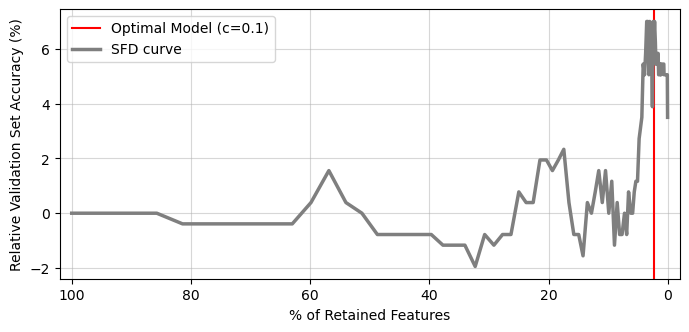

Optimal Model Size: 2.36% of full model


In [64]:
import matplotlib.pyplot as plt
percentage_vector = detach_matrix._percentage_vector
acc_curve = detach_matrix._sfd_curve

c = detach_matrix.trade_off

x_sfd=(percentage_vector) * 100
y_sfd=(acc_curve/acc_curve[0]-1) * 100

point_x = x_sfd[detach_matrix._max_index]
#point_y = y[DetachMatrixModel._max_index]

plt.figure(figsize=(8,3.5))
plt.axvline(x = point_x, color = 'r',label=f'Optimal Model (c={c})')
plt.plot(x_sfd, y_sfd, label='SFD curve', linewidth=2.5, color='C7', alpha=1)
#plt.scatter(point_x, point_y, s=50, marker='o', label=f'Optimal point (c={c})')

plt.grid(True, linestyle='-', alpha=0.5)
plt.xlim(102,-2)
plt.xlabel('% of Retained Features')
plt.ylabel('Relative Validation Set Accuracy (%)')
plt.legend()
plt.show()

print('Optimal Model Size: {:.2f}% of full model'.format(point_x))

### Keep the optimal features

In [65]:
if hasattr(detach_matrix, '_feature_mask'):
    feature_mask = detach_matrix._feature_mask
    
    selected_features_df = X.loc[:, feature_mask]
    selected_features_df = selected_features_df.assign(Label=y)
else:
    print("Feature mask not found in DetachMatrix object.")

### Train the model

In [16]:
n_features = len(selected_features_df.columns)-1 # last col is the label
for feats in [1, 10, 25, 50, 75, 100, 250]:
    print(train(runs=4, num_features=feats, df=combined_features_df))

NameError: name 'selected_features_df' is not defined